<a href="https://colab.research.google.com/github/raudh1/LorenzModel/blob/main/generate_trajectories/GenerateTrajLorenzRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GENERATE TRAJ

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from random import randint
import os
import sys
import string
#from torch import Dataset, Dataloader
from numpy import linalg as LA
from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
from generate import *


device= cpu


In [3]:
from matplotlib import pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Set files and directories

In [5]:
#DEFINE RNN

class Sequence(nn.Module):
    def __init__(self, hidden, layer, features, dropout):
        super(Sequence, self).__init__()
        self.hidden   = hidden
        self.layer    = layer
        self.features = features
        self.h_0 =torch.normal(mean=0.0, std=torch.ones(layer,1, hidden, dtype=torch.double)).to(device)

        self.rnn  = nn.RNN(self.features, self.hidden, self.layer, dropout=dropout)
        self.linear = nn.Linear(self.hidden, self.features)
 
    def forward(self, input, h_t=None):
        if h_t is None:
          h_t=self.h_0
        self.rnn.flatten_parameters()
        out, h_t = self.rnn(input, h_t)
        output = out.view(input.size(0)*input.size(1),self.hidden)
        output = self.linear(output)
        output = output.view(input.size(0),input.size(1),self.features)
        return output , h_t


    def predict(self, init_points,N=100, h_t=None):
        if h_t is None:
          h_t=self.h_0
        
        init_pred, h_t = self.forward(init_points, h_t)
        output=torch.zeros(init_pred.shape[0]+N,1,self.features)
        output[:init_pred.shape[0]]=init_pred
        inp = init_pred[-1].unsqueeze(0)
        
        for i in range(init_pred.shape[0],N+init_pred.shape[0]):

          inp, h_t =self.forward(inp,h_t)
          output[i]=inp

        return output


In [6]:
if __name__ == '__main__':
    np.random.seed(0)
    # load data and make training set
    hidden   = 100
    layer    = 1
    features = 3
    dropout  = 0
    # build the model
    case = 'FULL'
        
    ini = 25


In [7]:
k=0

train_data, valid_data, test_data=load_data(case,2)
print(train_data.shape)


seq = Sequence(hidden,layer,features,dropout).double().to(device)


torch.Size([10125, 1, 3])


In [17]:
train_loss, valid_loss = train(seq,train_data,valid_data,lr=0.01,epoch=500)

input shape= torch.Size([10125, 1, 3])  target shape = torch.Size([1687, 1, 3])
0 train loss 0.012840753762740345 valid loss 3.594397737298132
50 train loss 0.026667101448385137 valid loss 0.28633967620731154
100 train loss 0.01288108240503958 valid loss 0.27470605185344443
150 train loss 0.011414550483217035 valid loss 0.27355032955672953
200 train loss 0.010362916463879324 valid loss 0.2729116072717776
250 train loss 0.009462086325407404 valid loss 0.272279755028417
300 train loss 0.008669473828737527 valid loss 0.2715810022081645
350 train loss 0.007965631474587837 valid loss 0.27081528095691687
400 train loss 0.007336983775758653 valid loss 0.2699827162956759
450 train loss 0.006774628826599076 valid loss 0.2690818427697686
last epoch:  500


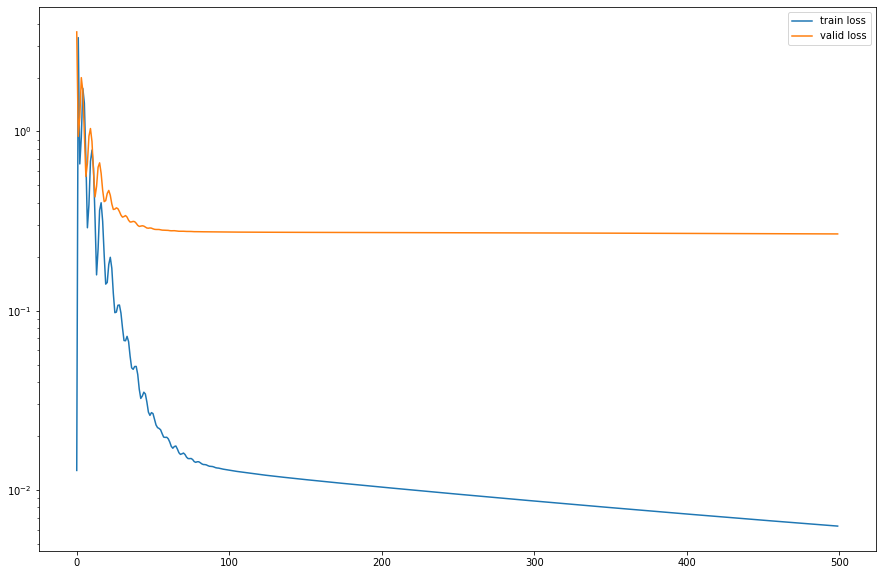

In [18]:
plt.figure(figsize=(15,10))

plt.plot(train_loss,label='train loss')
plt.plot(valid_loss,label='valid loss')
plt.semilogy()
plt.legend()
plt.show()

In [19]:
input=train_data   

   # Chose dataset you want to compare the model with
history=3000
future=1000
# def generate_traj(model,inp,h,f): # h is history and f is future inp is input that can be train or test or validation set
  # traj_1step ,_=  model(inp[:h+f])  # 1 step
  # traj = model.predict(inp[:h],N=f) #generated

  # return traj_1step.detach().numpy(), traj.detach().numpy()

**PLOT FUNCTIONS**

In [20]:
traj_1step_last_model, traj_generated_last_model = generate_traj(inp=input,model=seq,h=history,f=future)

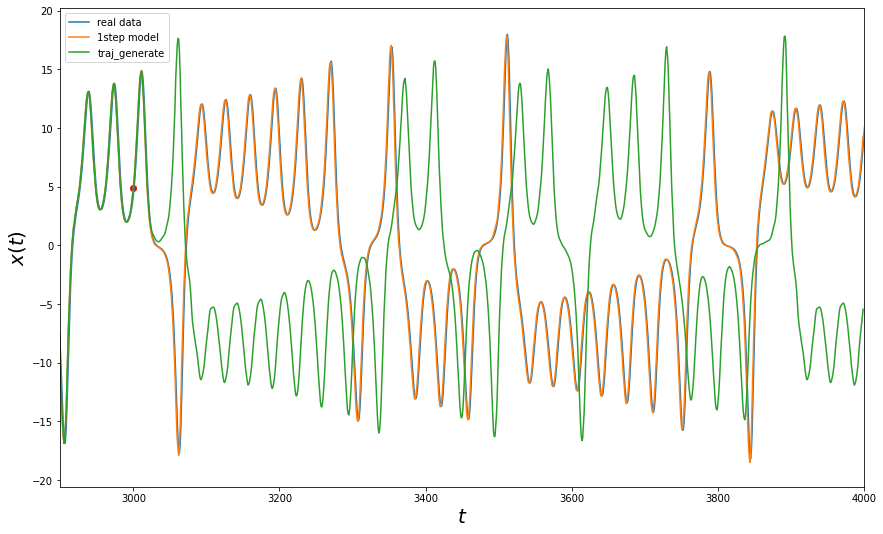

In [21]:
plot_traj(traj_1step_last_model,traj_generated_last_model,inp=input,coordinate='x',data=True,h=history,error=False)

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:189: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


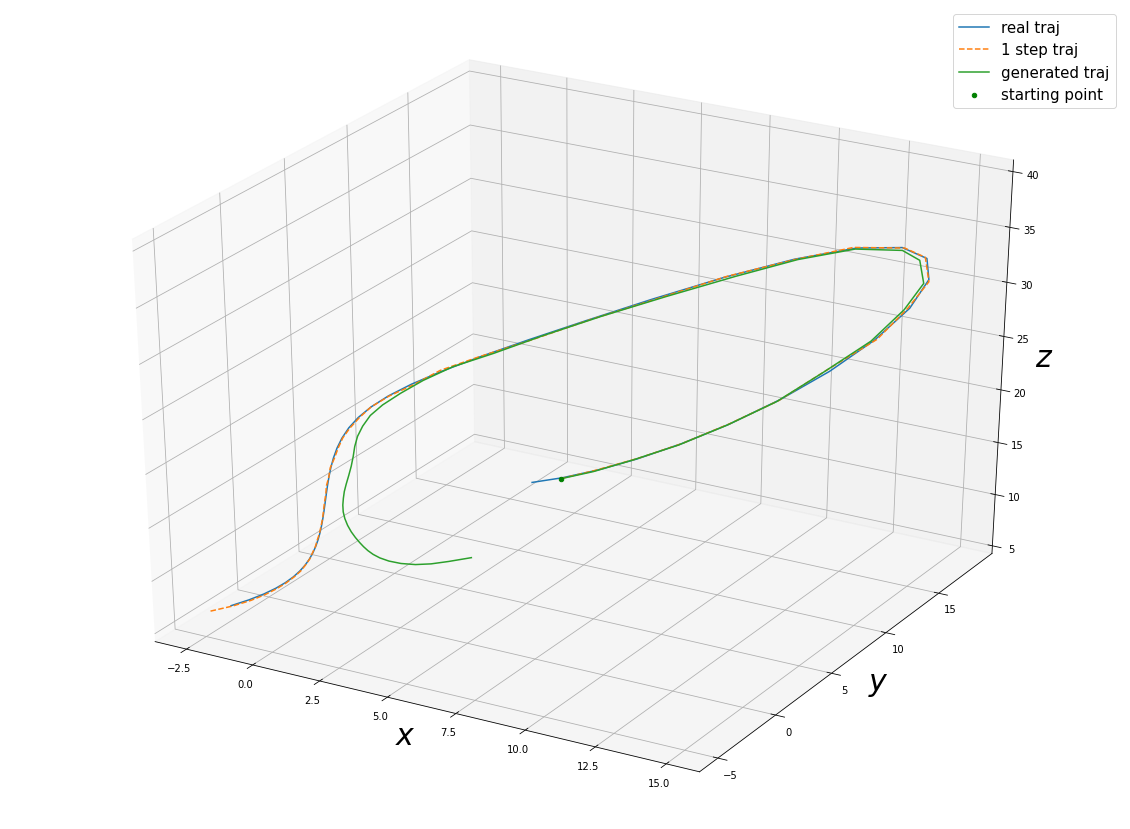

In [23]:
plot_traj_3D(traj_generated_last_model,traj_1step_last_model,inp=train_data,h=history,f=50,data=True) # plot 'future' points after 'history' points

Comparison with best model (min validation loss) 

In [30]:
bestmdl = Sequence(hidden,layer,features,dropout)
bestmdl.load_state_dict(torch.load('./param'))

best_traj_1step , best_traj=  generate_traj(bestmdl,inp=test_data,h=1000,f=600)

In [31]:
test_data.shape

torch.Size([1687, 1, 3])

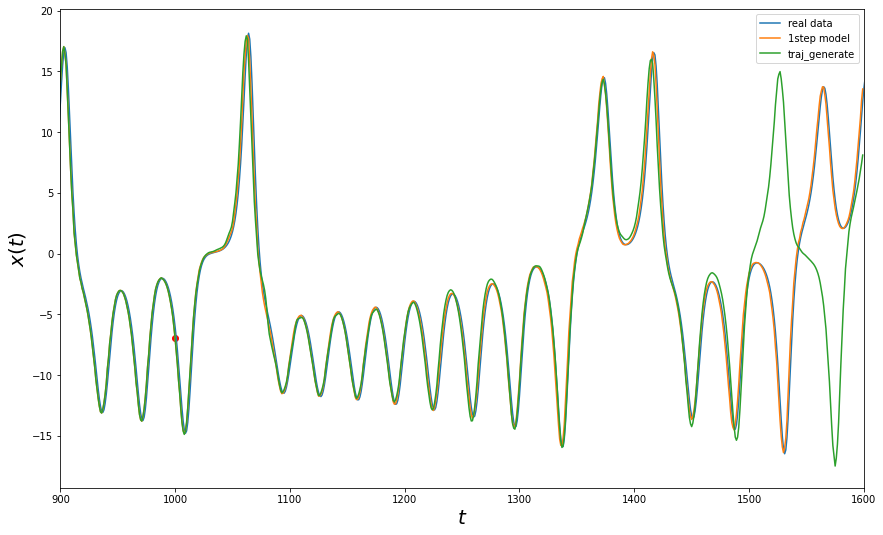

In [36]:
plot_traj(best_traj_1step,best_traj,inp=test_data,h=1000,data=True)

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:189: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


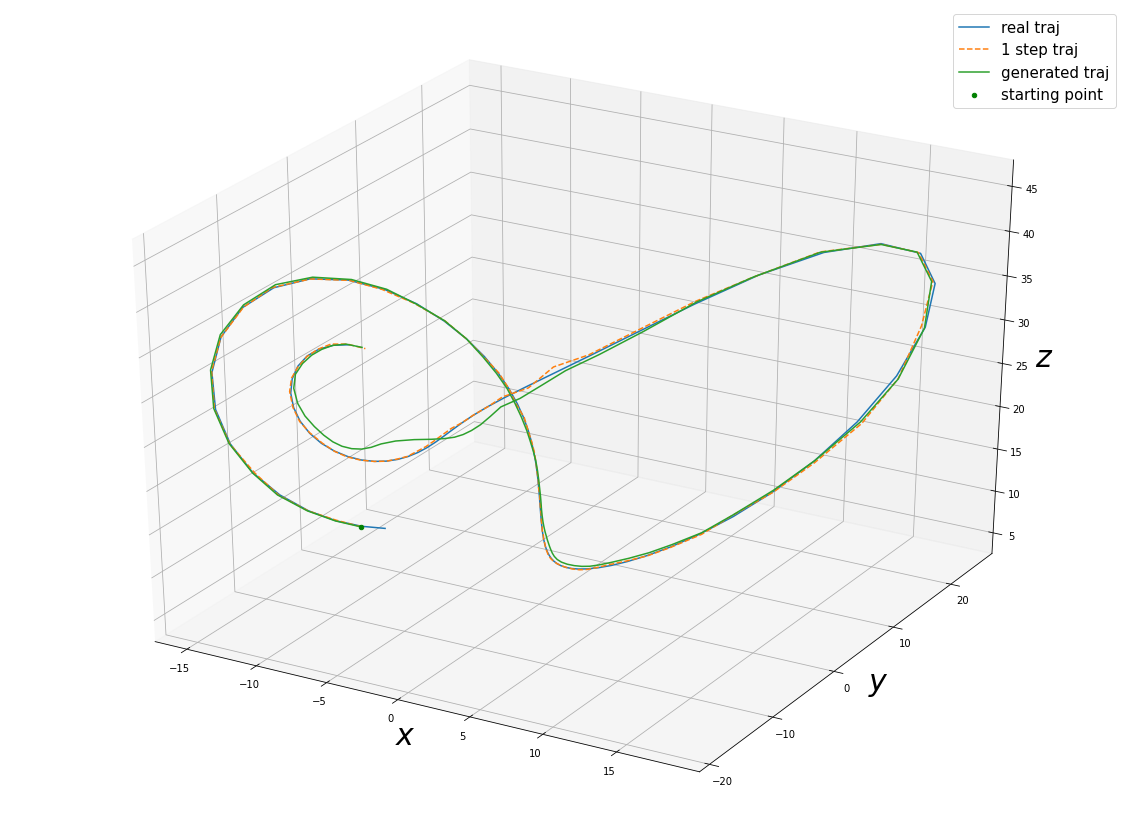

In [37]:
plot_traj_3D(best_traj,best_traj_1step,h=1000,f=100,inp=test_data)